# Deep drawing 3D shape prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import os
import sys
sys.path.insert(0, "../../src")
from cut_predictor import ProjectionPredictor
sys.path.insert(0, "/home/ingolf.lepenies/projects/ml_karoprod/ipynb/")
from banana_lib import UV2d

## Load the pretrained network

In [2]:
reg = ProjectionPredictor.from_h5('../../models/springback_uv_xyz.h5')
regr = ProjectionPredictor.from_h5('../../models/springback_uv_thickness.h5')

A nicer visualization method with plotly, a faster one with matplotlib

In [3]:
reg.position_attributes

['u', 'v']

In [4]:
param = {
        'Blechdicke': 1.01, 
        'Niederhalterkraft': 110.0, 
        'Ziehspalt': 2.4, 
        'Einlegeposition': -5, 
        'Ziehtiefe': 30,
        'Stempel_ID': 3,
        'E': 191.37245,
        'Rp0': 238.22696,
        'Rp50': 449.528189,
    }

In [5]:
df = pd.DataFrame({"v": np.linspace(0.,1,100), "u": .5})
dfr = reg.predict(param, df)
dfr

,v,u,x,y,z
0,0.000000,0.5,0.014267,-94.826859,2.014291
1,0.010101,0.5,-0.012421,-90.853508,2.028922
2,0.020202,0.5,-0.249634,-86.664955,2.101868
3,0.030303,0.5,-0.327362,-82.322403,2.168966
4,0.040404,0.5,-0.547134,-78.078232,2.160779
...,...,...,...,...,...
95,0.959596,0.5,1.520844,79.650749,2.368178
96,0.969697,0.5,1.617126,83.992760,2.605947
97,0.979798,0.5,1.627792,88.214928,2.876570
98,0.989899,0.5,1.683853,92.448250,3.229417


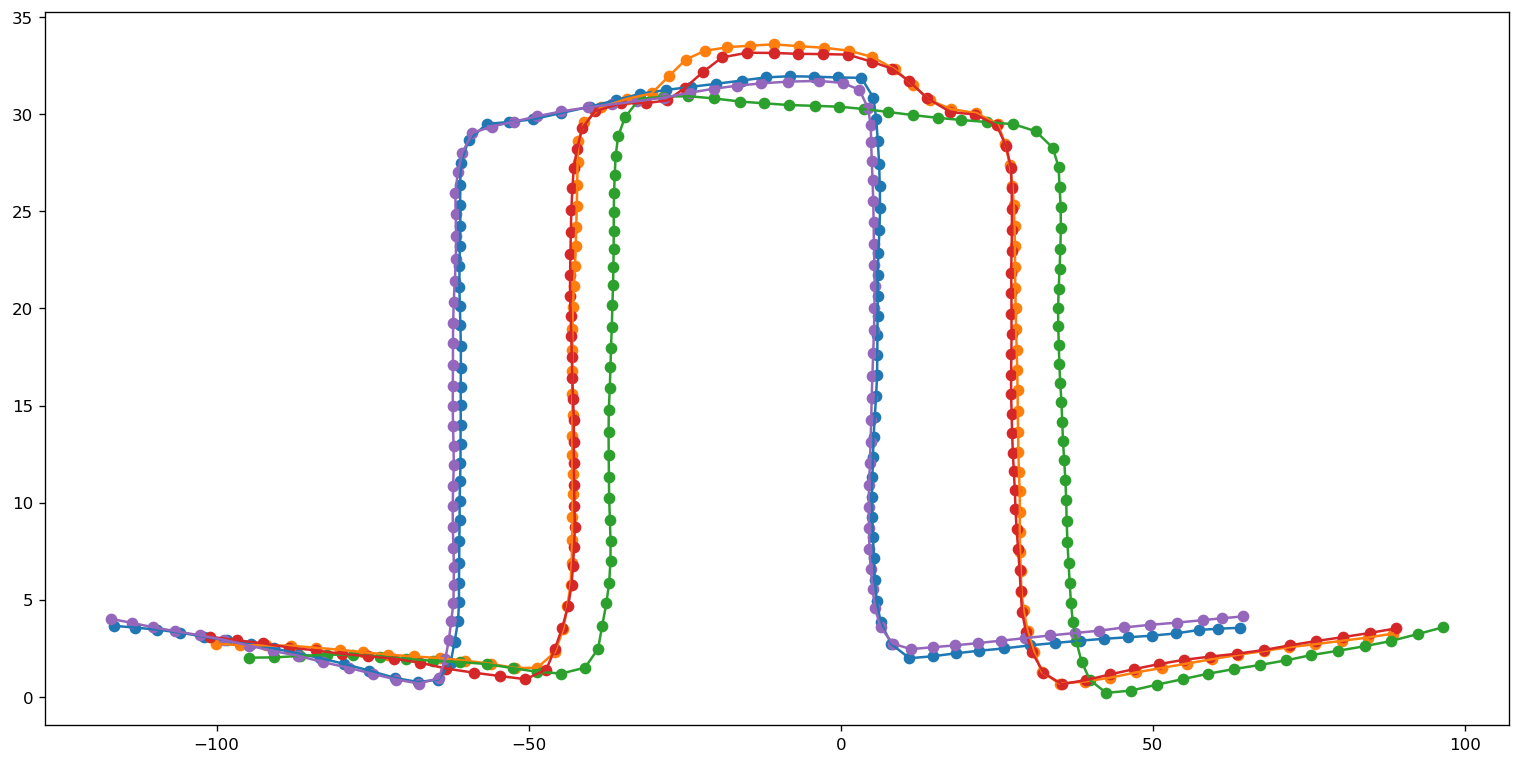

In [6]:
B = 400/25.4
H = 200/25.4
fig, ax = plt.subplots(1, figsize=(B, H))
for u in np.linspace(0.,1,5):
    df = pd.DataFrame({"v": np.linspace(0.,1,100), "u": u})
    dfr = reg.predict(param, df)
    ax.scatter(dfr.y, dfr.z)
    ax.plot(dfr.y, dfr.z)

In [7]:
param = {
        'Blechdicke': 1.01, 
        'Niederhalterkraft': 410.0, 
        'Ziehspalt': 2.4, 
        'Einlegeposition': -5, 
        'Ziehtiefe': 50,
        'Stempel_ID': 3,
        'E': 191.37245,
        'Rp0': 238.22696,
        'Rp50': 449.528189,
    }


In [29]:
import scale.fem.lsdyna.api as api
#mesh2d = api.BoxMesh2d(size=[1,1,0], elsize=[.01, .005, 1], pid=1)
elsize = .1
mesh2d = api.BoxMesh2d(size=[1,1,0], elsize=[elsize, elsize/2., 1], pid=1)
mesh2d.gen_box()
mesh2d.fix_column_types()
mesh2d#.info()
#mesh2d.nodes.dtypes
#mesh2dt = api.TriaMesh.from_mesh(mesh2d)
uv = mesh2d.get_plot_mesh()
uv.elements
uv.simplices()
uv.nodes

,nid,x,y,z
1,1,0.0,0.0,0.0
2,2,0.1,0.0,0.0
3,3,0.2,0.0,0.0
4,4,0.3,0.0,0.0
5,5,0.4,0.0,0.0
...,...,...,...,...
227,227,0.6,1.0,0.0
228,228,0.7,1.0,0.0
229,229,0.8,1.0,0.0
230,230,0.9,1.0,0.0


In [36]:
class UV2d0:
    def __init__(self, name=None, nodes=None, elements=None, simplices=None, elsize=.1, gen_mesh=True):
        if name is None:
            name = "N.N."
        self.metadata = {"name":name, "elsize":elsize}
        self.nodes = nodes
        self.elements = elements
        if gen_mesh is True:
            self.gen(elsize)
        
    def gen(self, elsize):
        mesh2d = api.BoxMesh2d(size=[1,1,0], elsize=elsize, pid=1)
        mesh2d.gen_box()
        mesh2d.fix_column_types()
        uv = mesh2d.get_plot_mesh()
        self.nodes = uv.nodes.rename(columns={"x":"u", "y":"v", "z":"w"})[["nid", "u", "v"]].copy()
        self.elements = uv.elements[["elid", "u", "v"]]#.rename(columns={"x":"u", "y":"v", "z":"w"})[["nid", "u", "v"]].copy()
        self.elements["simplices"] = pd.Series(uv.simplices().tolist(), index=self.elements.index)
    
    def load_h5(self, h5filepath):
        with pd.HDFStore(h5filepath, mode="r") as store:
            #            print(store.keys(), "/parameter" in store.keys())
            #self.simplices = store.get(f'/simplices')
            self.nodes = store.get(f'/nodes')
            self.elements = store.get(f'/elements')
            if "/metadata" in store.keys():
                self.metadata = store.get(f'/metadata').to_dict()
            else:
                self.metadata = {"name":"N.N.", "elsize":.1}

    def save_h5(self, h5filepath):
        with pd.HDFStore(h5filepath, mode="w") as store:
            #store.put(f'/simplices', self.simplices)
            store.put(f'/nodes', self.nodes)
            store.put(f'/elements', self.elements)
            store.put(f'/metadata', pd.Series(self.metadata))
            
    @classmethod        
    def from_h5(cls, filepath):
        uv = cls(gen_mesh=False)
        uv.load_h5(filepath)
        return uv
from scale.fem.boxmesh2d import UV2d        
elsize = .05
uv = UV2d(name=f"uv_{elsize}", elsize=[elsize, elsize/2., 0])
uv.elements
uv.nodes
#uv.simplices
filepath = f"/tmp/uv_{elsize}.h5"
uv.save_h5(filepath)
print(filepath)

/tmp/uv_0.05.h5


/home/ingolf.lepenies/projects/scale.fem3/scale/fem/boxmesh2d.py:45: RuntimeWarning: invalid value encountered in true_divide
  self.nel = np.asarray(self.size / self.elsize, int)
/home/ingolf.lepenies/projects/scale.fem3/scale/fem/boxmesh2d.py:873: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.elements["simplices"] = pd.Series(uv.simplices().tolist(), index=self.elements.index)
/home/ingolf.lepenies/projects/scale.fem3/scale/fem/boxmesh2d.py:890: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['simplices'], dtype='object')]

  store.put(f'/elements', self.elements)
/home/ingolf.lepenies/projects/scale.fem3/sc

In [10]:
sys.path.insert(0, "/home/ingolf.lepenies/projects/ml_karoprod/ipynb/")
from banana_lib import UV2d

In [28]:
elsize = 0.1
filepath = f"../../uvgrids/uv_{elsize}.h5"
uv = UV2d.from_h5(filepath)
uv.elements
uv.elements = regr.predict(param, uv.elements)
uv.elements = reg.predict(param, uv.elements)
uv.nodes = reg.predict(param, uv.nodes)
uv.metadata

OSError: ``../../uvgrids/uv_0.1.h5`` does not exist

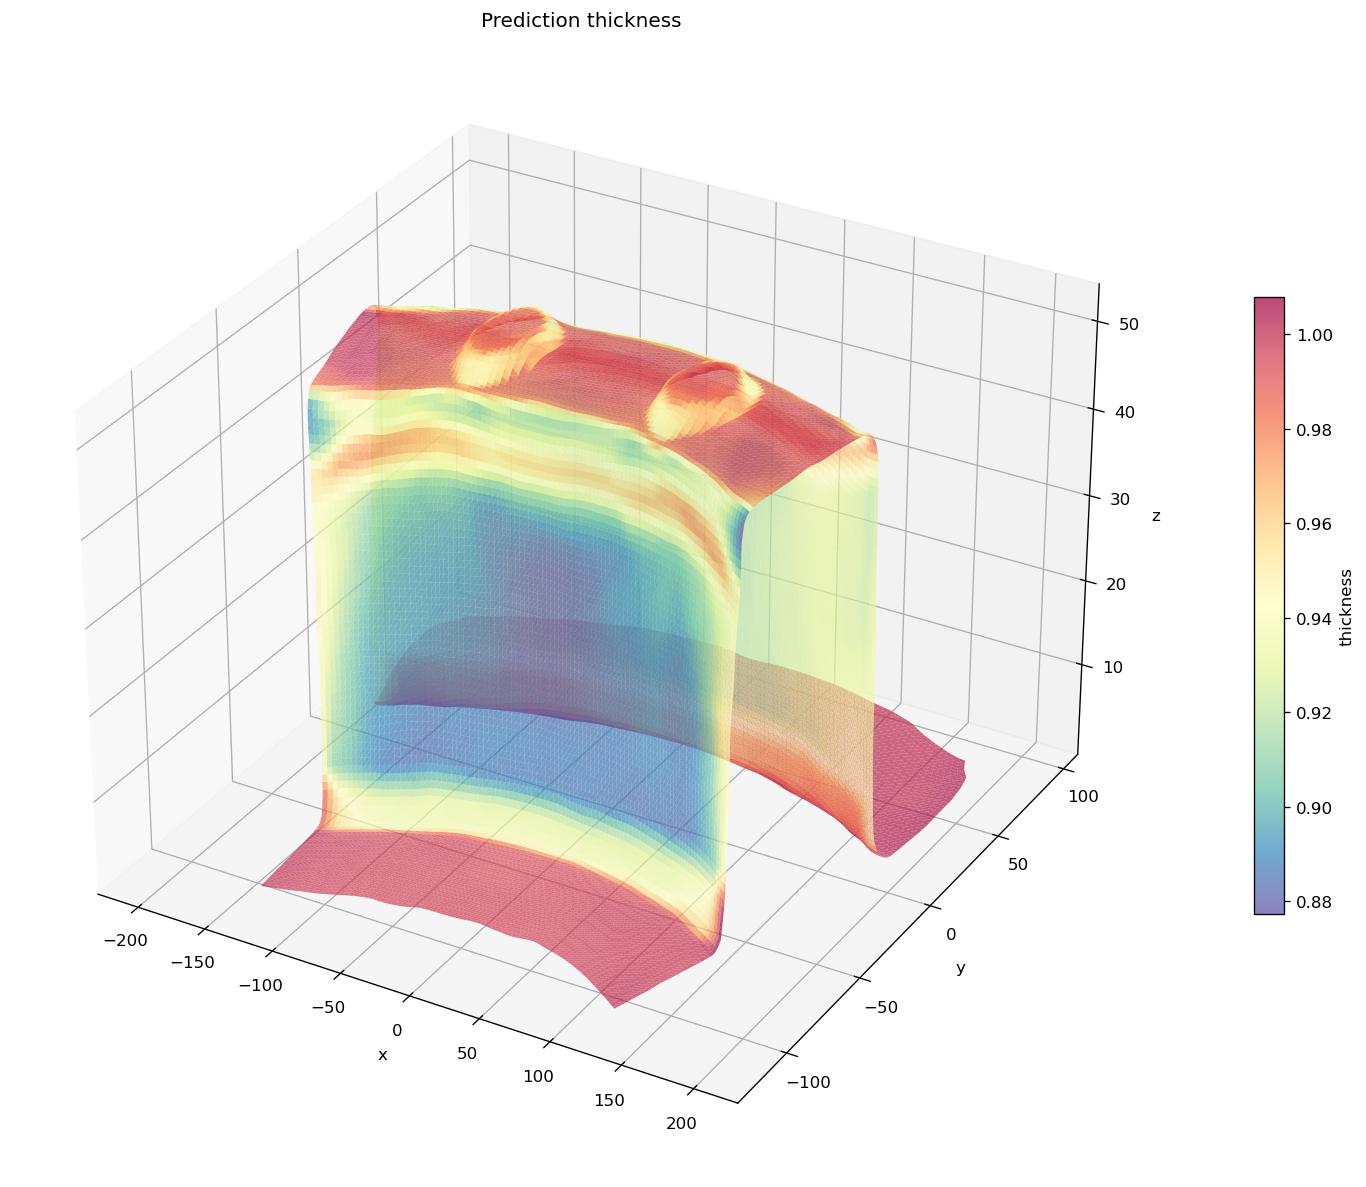

In [12]:
fig = plt.figure(1, figsize=(18,10))
ax = fig.add_subplot(111, projection="3d")
c = ax.plot_trisurf(uv.nodes.x, uv.nodes.y, uv.nodes.z, 
                triangles=uv.elements.simplices.tolist(), cmap=plt.cm.Spectral_r, 
                alpha=.7, shade=False, linewidth=2)
#c.colorbar()
result_name = "thickness"
c.set_array(uv.elements[result_name])
cbar = fig.colorbar(c, fraction=.015, label=result_name, ax=ax)
#c.set_facecolors(elcenterr.epseqpl)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title(f"Prediction {result_name}")
fig.tight_layout()

In [13]:
mesh = mesh2d.copy()
elcenter = mesh.calc_center()
mesh.elements = mesh.elements.merge(elcenter, #.rename(columns={"center_x":"x", "center_y":"y", "center_z":"z"}), 
                  left_on="elid", right_index=True)
mesh.elements["u"] = mesh.elements["center_x"]
mesh.elements["v"] = mesh.elements["center_y"]
mesh.elements["w"] = mesh.elements["center_z"]
mesh.elements.drop(columns= ["thickness"], inplace=True)
mesh.elements = regr.predict(param, mesh.elements)
mesh.elements = reg.predict(param, mesh.elements)
mesh.elements["type"] = 'shell4_thickness'
mesh.elements.thickness = pd.Series(np.vstack([mesh.elements.thickness, mesh.elements.thickness, mesh.elements.thickness, mesh.elements.thickness]).T.tolist(), index=mesh.elements.index)


mesh.nodes = mesh.nodes.rename(columns={"x":"u", "y":"v", "z":"w"})
mesh.nodes = reg.predict(param, mesh.nodes)
mesh.elements.head(1)
mesh.show_in()


 _____________________________________________________
 |                                                   |
 |     Livermore Software Technology Corporation     |
 |                                                   |
 |                L S - P R E P O S T                |
 |                                                   |
 |    Advanced Pre- and Post-Processor for LS-DYNA   |
 |                                                   |
 |       LS-PrePost(R) V4.8(Beta) - 30Jun2020        |
 |                                                   |
 |            LSTC Copyright (C) 1999-2019           |
 |                All Rights Reserved                |
 |___________________________________________________|

 OpenGL version 4.6.0 NVIDIA 510.47.03
Time to read keyword file = 0.287 seconds
Time to process element data = 0.011 seconds


In [14]:
msol = mesh.copy()
msol.elements = msol.offset_shells_center(mesh.elements, thickness=1, n_elements=1, pid=1)
msol.show_in()

/home/ingolf.lepenies/projects/scale.fem3/scale/fem/mesh.py:3328: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.nodes = self.nodes.append(enodes[["nid", "x", "y", "z", "iidx"]], sort=False)
/home/ingolf.lepenies/projects/scale.fem3/scale/fem/mesh.py:3347: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_elements_solid = all_elements_solid.append(elements_solid, sort=False)
/home/ingolf.lepenies/projects/scale.fem3/scale/fem/mesh.py:3349: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.elements = self.elements.append(all_elements_solid, sort=False)


In [15]:
mesh.elements.thickness = pd.Series(np.vstack(mesh.elements.thickness).tolist(), index=mesh.elements.index)
mesh.elements

,pid,elid,type,n_nodes,nodes,nidxs,beta,center_x,center_y,center_z,u,v,w,thickness,epseqpl,thinning,x,y,z
idx,,,,,,,,,,,,,,,,,,,
0,1,1,shell4_thickness,4,"[1, 2, 53, 52]","[1, 2, 53, 52]",NaN,0.01,0.005,0.0,0.01,0.005,0.0,"[0.9999681115150452, 0.9999681115150452, 0.999...",0.005661,1.007513,-126.180367,-113.557526,2.493684
1,1,2,shell4_thickness,4,"[2, 3, 54, 53]","[2, 3, 54, 53]",NaN,0.03,0.005,0.0,0.03,0.005,0.0,"[0.9996074438095093, 0.9996074438095093, 0.999...",0.005693,1.007140,-121.770050,-112.307915,2.398941
2,1,3,shell4_thickness,4,"[3, 4, 55, 54]","[3, 4, 55, 54]",NaN,0.05,0.005,0.0,0.05,0.005,0.0,"[0.9987169504165649, 0.9987169504165649, 0.998...",0.005310,1.007095,-117.015259,-111.040100,2.285547
3,1,4,shell4_thickness,4,"[4, 5, 56, 55]","[4, 5, 56, 55]",NaN,0.07,0.005,0.0,0.07,0.005,0.0,"[0.9973698854446411, 0.9973698854446411, 0.997...",0.004191,1.006944,-111.943069,-109.758080,2.205673
4,1,5,shell4_thickness,4,"[5, 6, 57, 56]","[5, 6, 57, 56]",NaN,0.09,0.005,0.0,0.09,0.005,0.0,"[0.9965438842773438, 0.9965438842773438, 0.996...",0.003273,1.006761,-106.795273,-108.581512,2.136959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,4996,shell4_thickness,4,"[5095, 5096, 5147, 5146]","[5095, 5096, 5147, 5146]",NaN,0.91,0.995,0.0,0.91,0.995,0.0,"[1.0004016160964966, 1.0004016160964966, 1.000...",0.000598,1.007811,154.598114,73.873970,2.845449
4996,1,4997,shell4_thickness,4,"[5096, 5097, 5148, 5147]","[5096, 5097, 5148, 5147]",NaN,0.93,0.995,0.0,0.93,0.995,0.0,"[1.0000172853469849, 1.0000172853469849, 1.000...",0.000123,1.007671,162.196320,72.043404,2.829757
4997,1,4998,shell4_thickness,4,"[5097, 5098, 5149, 5148]","[5097, 5098, 5149, 5148]",NaN,0.95,0.995,0.0,0.95,0.995,0.0,"[1.000864863395691, 1.000864863395691, 1.00086...",-0.000206,1.007729,169.671173,70.090080,2.876449
